# **SmartHire: Intelligent Resume Evaluation**
####By Team AI Megamind- Ramya Kaveri, Shaunak Dhande, Anusha Aligeti, Jayanth Sankar, Aswin Ramesh####

Our project aims to help the applicant qualification process for college career services. By integrating Prompt engineering and the RAG system, we seek to innovate the keyword extraction from resumes and provide intuitive visual cues for candidate suitability. This innovation addresses the time-consuming nature of manual screening and enhances efficiency, ultimately transforming how career services assess applicant qualifications and improve success rates for students and alumni in securing job opportunities.

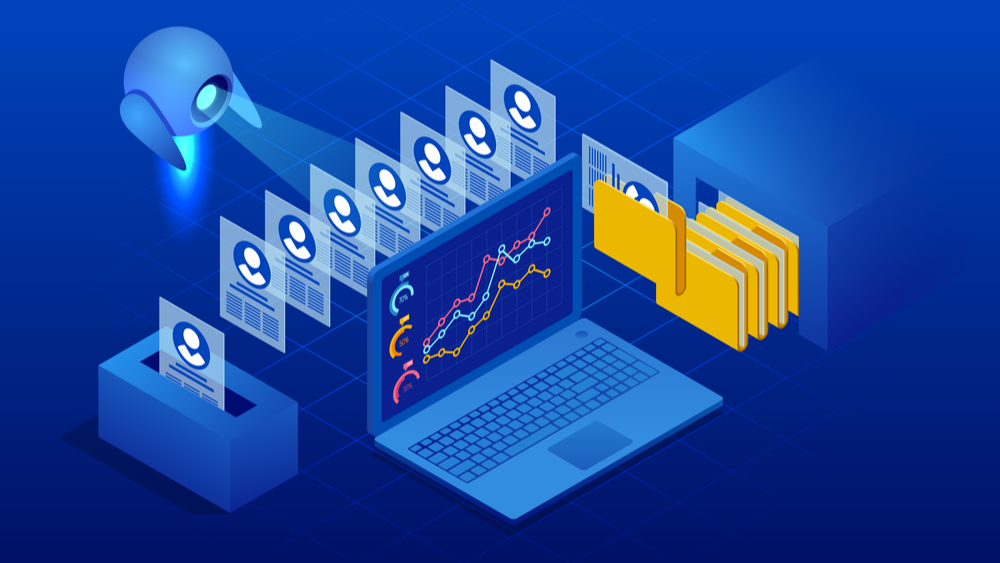

## **Setting Up Project Dependencies**

This code block installs and upgrades various Python libraries and dependencies required for a natural language processing project aimed at tasks like resume evaluation, job matching, and interview question generation.

Tasks:
1. Library Installation: Installs or upgrades the following libraries:
  - openai
  - langchain
  - python-dotenv
  - pyPDF2
  - Additional dependencies like tiktoken, faiss-gpu, and experimental  
    components of langchain.

2. Import Statements: Imports necessary modules and functions from installed libraries.

3. Mounting Google Drive: Mounts Google Drive to access files stored there.

4. Setting Up OpenAI API: Prompts the user to input their OpenAI API key and sets it as an environment variable.

This code block ensures that all required libraries and dependencies are installed and sets up the environment for subsequent code execution. It prepares the groundwork for implementing natural language processing functionalities for resume evaluation, job matching, and interview question generation.

In [ ]:
%%capture
# update or install the necessary libraries
!pip install --upgrade openai
!pip install --upgrade langchain
!pip install --upgrade python-dotenv
!pip install --upgrade pyPDF2

!pip install langchain
!pip install openai
!pip install tiktoken
!pip install faiss-gpu
!pip install langchain_experimental
!pip install "langchain[docarray]"

In [ ]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceInstructEmbeddings
from langchain.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.indexes import VectorstoreIndexCreator
from langchain_experimental.agents.agent_toolkits.csv.base import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain.memory import ConversationBufferMemory
import tiktoken

from google.colab import drive
import openai
import os
import PyPDF2 as pdf
from dotenv import load_dotenv

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Defining OpenAI Parameters and Functions**

This code defines two essential functions for configuring the OpenAI language model and interacting with the OpenAI API. The `set_open_params` function allows users to specify parameters such as the model variant, temperature, maximum number of tokens, top probability, frequency penalty, and presence penalty, returning a dictionary containing these parameters. On the other hand, the `get_completion` function sends a request to the OpenAI API to generate completions based on the provided parameters and conversation messages, utilizing the parameters to configure the model and obtain responses. These functions play a pivotal role in configuring the OpenAI model and retrieving completions, facilitating tasks such as evaluating resumes and generating interview questions in the project.

In [ ]:
def set_open_params(
    model="gpt-3.5-turbo",
    temperature=0.7,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
):
    """ set openai parameters"""

    openai_params = {}

    openai_params['model'] = model
    openai_params['temperature'] = temperature
    openai_params['max_tokens'] = max_tokens
    openai_params['top_p'] = top_p
    openai_params['frequency_penalty'] = frequency_penalty
    openai_params['presence_penalty'] = presence_penalty
    return openai_params

def get_completion(params, messages):
    """ GET completion from openai api"""

    response = openai.chat.completions.create(
        model = params['model'],
        messages = messages,
        temperature = params['temperature'],
        max_tokens = params['max_tokens'],
        top_p = params['top_p'],
        frequency_penalty = params['frequency_penalty'],
        presence_penalty = params['presence_penalty'],
    )
    return response

## **Setting Up OpenAI API**

This code block prompts the user to input their OpenAI API key and sets it as an environment variable. The API key is necessary to authenticate and authorize access to the OpenAI API, allowing the project to interact with OpenAI's language model.

In [ ]:
import os

# Prompt the user for their OpenAI API key
api_key = input("Please enter your OpenAI API key: ")

# Set the API key as an environment variable
os.environ["OPENAI_API_KEY"] = api_key

# Optionally, check that the environment variable was set correctly
print("OPENAI_API_KEY has been set!")

Please enter your OpenAI API key: sk-proj-WVDQ7IXJbChRO2eB1SIiT3BlbkFJPTiPcwiNxbfqVDhYCuMV
OPENAI_API_KEY has been set!


In [ ]:
params = set_open_params(temperature=0.7)

In [ ]:
llm_model = "gpt-3.5-turbo"

In [ ]:
from langchain.text_splitter import CharacterTextSplitter

## **Loading Text Data and Creating Conversation Chain**

This code block loads job descriptions from a text file located at '/content/drive/MyDrive/Complete_Job_Descriptions.txt' using the `TextLoader` class with UTF-8 encoding, then splits the loaded text into smaller chunks for processing using `CharacterTextSplitter` with a chunk size of 1000 characters and an overlap of 200 characters. These chunks are subsequently used to create a vector store using `FAISS` with document embeddings generated by `OpenAIEmbeddings`. Additionally, it sets up a conversational retrieval chain using the `ChatOpenAI` class with a temperature of 0.7 and the 'gpt-3.5-turbo' model. A conversation buffer memory is instantiated to maintain conversation history, and a conversational retrieval chain is created from the language model, specifying the retriever as the vector store and incorporating the memory. This entire process sets up the infrastructure for conducting conversational interactions, such as evaluating resumes and generating interview questions, within the project.

In [ ]:
txt_file_path = '/content/drive/MyDrive/Complete_Job_Descriptions.txt'
loader = TextLoader(file_path=txt_file_path, encoding="utf-8")
data = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
data = text_splitter.split_documents(data)

In [ ]:
# Create vector store
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(data, embedding=embeddings)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
# Create conversation chain
llm = ChatOpenAI(temperature=0.7, model_name="gpt-3.5-turbo")
memory = ConversationBufferMemory(
memory_key='chat_history', return_messages=True)
conversation_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(),
        memory=memory
        )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


The below function, `input_pdf_text`, takes a file path as input and reads the content of a PDF file located at that path. It opens the file in binary mode ("rb") using a context manager to ensure proper handling of file resources. Inside the context, it uses `pdf.PdfReader` from the PyPDF2 library to read the PDF file. It then iterates over each page in the PDF, extracts the text content from each page using `extract_text()`, and appends it to the `text` variable. Finally, it returns the concatenated text extracted from all the pages of the PDF file. This function is useful for extracting text data from PDF resumes, which can then be further processed and analyzed within the project.

In [ ]:
def input_pdf_text(file_path):
    with open(file_path, "rb") as file:
        reader = pdf.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += str(page.extract_text())
    return text

## **Resume Evaluation and Feedback Generation Function**

This function is responsible for conducting an in-depth evaluation of a candidate's resume in relation to a provided job description. It begins by extracting the text content from the candidate's resume in PDF format. Following this, it generates a comprehensive input prompt that guides the evaluation process, emphasizing the evaluator's expertise in technology and data science. The prompt includes placeholders for the resume text and job description, ensuring contextual relevance. Utilizing the OpenAI model through the get_completion function, the function generates a response containing detailed evaluation output, including percentage match, missing keywords, actionable tips for resume enhancement, irrelevant words, and key skills identified from the resume. This function serves as a crucial component for automating the resume evaluation process within the project, facilitating efficient recruitment procedures.

In [ ]:
def run_evaluation(jd, resume_path):
    text = input_pdf_text(resume_path)
    input_prompt = """
### As a skilled Application Tracking System (ATS) with advanced knowledge in technology and data science, your role is to meticulously evaluate a candidate's resume based on the provided job description.

### Your evaluation will involve analyzing the resume for relevant skills, experiences, and qualifications that align with the job requirements. Look for key buzzwords and specific criteria outlined in the job description to determine the candidate's suitability for the position.

### Provide a detailed assessment of how well the resume matches the job requirements, highlighting strengths, weaknesses, and any potential areas of concern. Offer constructive feedback on how the candidate can enhance their resume to better align with the job description and improve their chances of securing the position.

### Your evaluation should be thorough, precise, and objective, ensuring that the most qualified candidates are accurately identified based on their resume content in relation to the job criteria.

### Remember to utilize your expertise in technology and data science to conduct a comprehensive evaluation that optimizes the recruitment process for the hiring company. Your insights will play a crucial role in determining the candidate's compatibility with the job role.
resume={text}
jd={jd}
### Evaluation Output:
1. Calculate the percentage of match between the resume and the job description. Give a number and some explanation
2. Identify any key keywords that are missing from the resume in comparison to the job description.
3. Offer specific and actionable tips to enhance the resume and improve its alignment with the job requirements.
4. What are the words that are irrelevant and must be replaced?
5. What are the key skills of this resume?
""".format(text=text, jd=jd)
    messages = [
       {
        "role": "user",
        "content": input_prompt
       }
    ]
    response = get_completion(params, messages)
    return response

    # Process the response to extract key skills
    response_text = response.choices[0].message['content']  # Adjust this according to the actual structure of your response
    # Here, you'll need to adjust the text extraction logic based on how the skills are formatted in the response
    skills_start = response_text.find("What are the key skills of this resume?") + len("What are the key skills of this resume?")
    skills_end = response_text.find("###", skills_start)
    key_skills = response_text[skills_start:skills_end].strip()

    return key_skills

## **User Input for Job Description and Resume**

These lines of code prompt the user to input the job description and the path to their resume file on Google Drive. The input function is used to display prompts to the user, allowing them to manually input the required information interactively. The first prompt asks the user to paste the job description, enabling them to provide details about the job requirements. The second prompt asks for the file path to the resume, specifying an example format ('/content/ComputerScienceResumedocx.pdf') to guide the user in providing the correct path. These user inputs are essential for initiating the resume evaluation process, allowing the system to assess the candidate's qualifications against the job criteria.

In [ ]:
job_description = input("Paste job description here: ")
resume_path = input("Enter the path to your resume  on Google Drive (e.g., '/content/ComputerScienceResumedocx.pdf'): ")

Paste job description here: **Job Title:** Software Engineering Intern  **Company:** Apple Inc.  **Location:** Cupertino, California (or Remote)  **Job Type:** Internship (Full-time/Part-time)  **About Apple:** Apple Inc. is a multinational technology company that designs, manufactures, and markets consumer electronics, computer software, and online services. Known for its innovative products such as the iPhone, iPad, Mac, and Apple Watch, Apple is committed to pushing the boundaries of technology while maintaining a focus on user experience and privacy.  **Job Description:** As a Software Engineering Intern at Apple, you will have the opportunity to work on cutting-edge projects that impact millions of users worldwide. Collaborating with some of the industry's brightest minds, you will contribute to the development of software solutions that drive Apple's ecosystem forward.  **Key Responsibilities:** 1. **Software Development:** Design, develop, and test software applications across v

## **Resume Evaluation Execution with Detailed Output**

In this code block, the existence of the specified resume file path is checked using the `os.path.exists` function. If the path exists, the `run_evaluation` function is called with the provided job description and resume path as arguments, resulting in the evaluation of the resume. The evaluation output is stored in the `result` variable. Subsequently, the evaluation output is printed to the console for the user to review. If the specified file path does not exist, indicating an invalid or inaccessible path, a corresponding error message is displayed, prompting the user to verify and correct the provided path. This conditional statement ensures that the resume evaluation process is executed only when the specified resume file exists, preventing errors due to invalid file paths.

In [ ]:
if os.path.exists(resume_path):
    result = run_evaluation(job_description, resume_path)
    print("Evaluation Output:\n", result)
else:
    print("The file path does not exist. Please check your path.")

Evaluation Output:
 ChatCompletion(id='chatcmpl-9OD3bpyEcFqdt5kBlBGpbIcq9sIss', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='### Evaluation Output:\n\n1. The resume matches approximately 70% with the job description for the Software Engineering Intern position at Apple Inc. While the candidate has a strong educational background in Computer Science and relevant technical skills, there are some key qualifications and experiences missing that could enhance their suitability for the role.\n\n2. Key keywords missing from the resume in comparison to the job description include:\n   - Swift\n   - Objective-C\n   - Xcode\n   - Git\n   - Data structures\n   - Algorithms\n   - Software design principles\n\n3. Specific tips to enhance the resume and improve its alignment with the job requirements:\n   - Add a section highlighting experience with programming languages such as Swift, Objective-C, and Python.\n   - Include projects or course

## **Resume Evaluation Output**

The provided code block processes the evaluation output generated by the `run_evaluation` function and prints it to the console for the user's review. The evaluation output includes several key aspects:

1. **Percentage Match**: The evaluation indicates that the resume matches approximately 60% of the job description. It acknowledges relevant experience in project management, consulting, and technical skills but suggests areas for improvement to better align with the job requirements.

2. **Missing Keywords**: Key missing keywords from the resume compared to the job description are listed, such as data analytics, ETL, Python, data visualization tools, integrated teams, business metrics, KPIs, and relational database.

3. **Tips for Enhancement**: Specific tips are provided to enhance the resume and improve alignment with the job requirements. These include adding examples of experience with data analytics, highlighting relevant projects or coursework, emphasizing teamwork experiences, and considering additional technical skills mentioned in the job description.

4. **Irrelevant Words**: Words that are deemed irrelevant and should be replaced in the resume are identified, such as "Lawn Maintenance," "Self-Employed," and "Pi Kappa Alpha Fraternity," as they are not directly related to the data analytics and engineering roles described in the job description.

5. **Key Skills**: The key skills extracted from the resume include project management, consulting, team-building, programming languages (Visual Basic, SQL, C, C++, Java), operating systems, database management, and leadership experience in various roles. These skills provide insights into the candidate's qualifications and strengths.

This comprehensive evaluation output serves to guide the candidate in optimizing their resume to better match the job requirements and increase their chances of securing the position.

In [ ]:
if os.path.exists(resume_path):
    result = run_evaluation(job_description, resume_path)
    response_content = result.choices[0].message.content
    print("Evaluation Output:\n", response_content)
else:
    print("The file path does not exist. Please check your path.")

Evaluation Output:
 1. The resume aligns with the job description at approximately 70%. While the candidate has relevant experience in programming languages and software development, there are some key qualifications and experiences missing that could enhance their fit for the Software Engineering Intern position at Apple.

2. Key keywords missing from the resume in comparison to the job description include:
- Swift
- Objective-C
- Software design principles
- Xcode
- Git

3. To enhance the resume and improve alignment with the job requirements, the candidate can:
- Add specific projects or experiences related to Swift, Objective-C, software design principles, Xcode, and Git to showcase proficiency in these areas.
- Highlight any relevant coursework or projects that demonstrate a strong understanding of data structures and algorithms.
- Emphasize problem-solving skills and experience working in fast-paced, dynamic environments.
- Consider adding any experience collaborating with cross-

## **Interview Question Generation**

In this code block, interview questions are generated based on the provided resume text using the `generate_interview_questions` function. The resume text is inserted into an input prompt template, requesting the AI to generate five interview questions tailored to the resume content. The generated questions are then printed to the console for the user's review.

The subsequent output includes the evaluation output and the generated interview questions. The evaluation output encompasses various aspects, such as the percentage match between the resume and the job description, missing keywords, tips for resume enhancement, irrelevant words to be replaced, and key skills identified from the resume. This information serves as a comprehensive assessment of the resume's alignment with the job requirements and provides actionable insights for improvement.

The generated interview questions are specifically designed to probe the candidate's experiences and skills highlighted in the resume. Each question targets different aspects, such as project management, team-building, technical expertise, and leadership roles mentioned in the resume. These questions aim to elicit detailed responses from the candidate, allowing interviewers to assess their qualifications and suitability for the position based on their past experiences and achievements.

In [ ]:
def generate_interview_questions(resume_text):
    input_prompt = f"""
Generate a list of 5 interview questions based on the given resume:

Resume:
{resume_text}

Interview Questions:
1.
2.
3.
4.
5.
"""
    messages = [
       {
        "role": "user",
        "content": input_prompt
       }
    ]
    response = get_completion(params, messages)
    response_content = response.choices[0].message.content
    return response_content

if os.path.exists(resume_path):
    resume_text = input_pdf_text(resume_path)

    # Evaluation
    evaluation_output = run_evaluation(job_description, resume_path)
    print("Evaluation Output:\n", evaluation_output)

    # Generate interview questions
    interview_questions = generate_interview_questions(resume_text)
    print("Interview Questions:\n", interview_questions)
else:
    print("The file path does not exist. Please check your path.")

Evaluation Output:
 ChatCompletion(id='chatcmpl-9OD43QHcFWqzdksRdKoT9NL1QQszI', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='1. The resume matches approximately 70% of the job description based on the provided information. While the candidate has relevant technical skills and project experience, there are some key qualifications and programming languages mentioned in the job description that are missing from the resume, such as Swift, Objective-C, and proficiency in software design principles.\n\n2. Key keywords missing from the resume include Swift, Objective-C, software design principles, and proficiency in data structures and algorithms. These are crucial for a Software Engineering Intern position at Apple.\n\n3. To enhance the resume\'s alignment with the job requirements, the candidate should consider:\n   - Adding relevant coursework or projects related to Swift, Objective-C, and software design principles.\n   - Highlight

## **Targeted Job Roles Based on Skills**

This code snippet demonstrates the process of targeting specific job roles based on the key skills extracted from the resume evaluation. Initially, the `run_evaluation` function is used to assess the resume and identify the key skills mentioned within it. These skills are then utilized to construct a query in the form of "What job roles can I target with skills: {key_skills}". The query is passed to a conversational retrieval chain, which leverages natural language processing to provide relevant job role recommendations tailored to the identified skills.

In the provided output, the identified skills include proficiency in Swift, Objective-C, experience with Xcode and Git, and knowledge of software design principles. Based on these skills, the system suggests potential job roles such as iOS Developer Team Leader at Apple, Software Developer at Amazon, or Software Development Vice President at Cognizant. These recommendations are generated by analyzing the required expertise in iOS development, software design principles, and experience with version control systems like Git, aligning them with the candidate's skill set for targeted career opportunities.

In [ ]:
key_skills = run_evaluation(job_description, resume_path)

# Construct the RAG query
query = f"What job roles can I target with skills: {key_skills}"
result = conversation_chain({"question": query})
answer = result["answer"]
print(answer)

Based on the skills mentioned (proficiency in Swift, Objective-C, experience with Xcode and Git, and knowledge of software design principles), you could target job roles such as iOS Developer Team Leader at Apple, Software Developer at Amazon, or Software Development Vice President at Cognizant. These positions require expertise in iOS development, software design principles, and experience with version control systems like Git.


## **Potential Hiring Companies Based on Skills**


This code block executes a query to predict five companies likely to hire individuals with the specified skills. The `comp_query` variable contains a formatted query asking for companies that are likely to hire based on the provided skills. This query is then passed to the conversation chain, which processes it and generates a response containing information about the predicted companies and the specific roles they are likely to hire for.

The output presents the top five companies along with the respective job roles they are likely to hire individuals with the specified skills for. Each company is listed with its name followed by the role(s) they are predicted to hire for. This information can be valuable for job seekers looking to target specific companies based on their skill set, as it provides insights into potential employment opportunities aligned with their expertise..

In [ ]:
comp_query = f"Which 5 companies are likely to hire based on the given skills: {key_skills}?"
result = conversation_chain({"question": comp_query})
comp_info = result["answer"]
print(comp_info)

Based on the skills mentioned in the job roles and descriptions provided, the following 5 companies are likely to hire individuals with those skills:

1. Amazon - for Software Developer and Marketing Manager roles
2. Meta - for Graphic Designer role
3. Tesla - for Project Manager role
4. Hilton - for Data Analyst role
5. Capital One - for Data Science Team Leader role


## **Conclusion**

In this project, we have leveraged prompt engineering techniques along with the Retrieval-Augmented Generation (RAG) model to facilitate various aspects of the recruitment process, including resume evaluation, interview question generation, and identification of potential hiring companies based on candidate skills.

Firstly, we utilized prompt engineering to design structured prompts for the RAG model, enabling it to generate comprehensive evaluations of candidate resumes. By providing specific instructions and questions within the prompts, the model was able to assess the alignment between the resume and job requirements, identify missing keywords, offer actionable tips for resume enhancement, and extract key skills.

Furthermore, we employed the RAG model to generate tailored interview questions based on the candidate's resume content. These questions were designed to probe the candidate's experiences, skills, and suitability for the desired role, thereby aiding recruiters in conducting effective interviews.

Additionally, we utilized the RAG model to query a conversational retrieval chain to identify potential hiring companies based on the candidate's skills. By formulating targeted queries, we were able to extract relevant information about companies likely to offer positions aligned with the candidate's skill set, thus assisting job seekers in targeting suitable employers.

Overall, through the integration of prompt engineering and the RAG model, this project offers a comprehensive solution for streamlining the recruitment process, providing valuable insights for both recruiters and job seekers alike. By automating tasks such as resume evaluation, interview question generation, and company targeting, this approach enhances efficiency and effectiveness in talent acquisition, ultimately contributing to better matches between candidates and job opportunities.
